# Assignment

In [1]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *

size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [2]:
## INITIALISE THE ENVIRONMENT
env = Chess_Env(size_board)

In [3]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S, X, allowed_a = env.Initialise_game()  # INTIALISE GAME

print(S)  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ', env.check)  # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ', np.sum(env.dfk2_constrain).astype(int))  # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO

for i in range(5):

    a, _ = np.where(allowed_a == 1)  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent = np.random.permutation(a)[0]  # MAKE A RANDOM ACTION

    S, X, allowed_a, R, Done = env.OneStep(a_agent)  # UPDATE THE ENVIRONMENT

    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R, '', Done)
    print('check? ', env.check)
    print('dofk2 ', np.sum(env.dfk2_constrain).astype(int))

    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break



[[3 0 0 0]
 [0 0 0 2]
 [0 0 0 0]
 [0 0 1 0]]
check?  0
dofk2  1

[[0 3 0 0]
 [0 0 0 2]
 [0 1 0 0]
 [0 0 0 0]]
0  0
check?  0
dofk2  1

[[3 0 0 0]
 [0 0 0 2]
 [0 0 0 0]
 [0 0 1 0]]
0  0
check?  0
dofk2  1

[[0 0 0 0]
 [3 0 0 0]
 [0 0 2 0]
 [0 0 1 0]]
0  0
check?  0
dofk2  1

[[0 0 0 0]
 [0 3 0 0]
 [0 0 0 2]
 [0 0 1 0]]
0  0
check?  0
dofk2  3

[[0 0 0 2]
 [3 0 0 0]
 [0 0 0 0]
 [0 0 1 0]]
0  0
check?  0
dofk2  2


In [4]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S, X, allowed_a = env.Initialise_game()
N_episodes = 1000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):

    S, X, allowed_a = env.Initialise_game()  # INITIALISE GAME
    Done = 0  # SET Done=0 AT THE BEGINNING
    i = 1  # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE

    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done == 0:

        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 

        a, _ = np.where(allowed_a == 1)
        a_agent = np.random.permutation(a)[0]

        S, X, allowed_a, R, Done = env.OneStep(a_agent)

        if Done:
            R_save_random[n] = np.copy(R)
            N_moves_save_random[n] = np.copy(i)
            break

        i = i + 1  # UPDATE THE COUNTER

# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:', np.mean(R_save_random), 'Number of steps: ', np.mean(N_moves_save_random))

Random_Agent, Average reward: 0.171 Number of steps:  7.28


## Task 3
The following is an implementation of **SARSA**.

In [5]:
from Assignment.Network import Network

# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S, X, allowed_a = env.Initialise_game()
N_a = np.shape(allowed_a)[0]  # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in = np.shape(X)[0]  ## INPUT SIZE
N_h = 200  ## NUMBER OF HIDDEN NODES

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2  # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005  # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85  # THE DISCOUNT FACTOR
eta = 0.0035  # THE LEARNING RATE

N_episodes = 10000#0  # THE NUMBER OF GAMES TO BE PLAYED

## INITALISE YOUR NEURAL NETWORK...
network_sarsa = Network(N_h, N_in, N_a, eta=eta)

In [6]:
def epsilon_greedy_policy(Qvalues, epsilon):
    N_class = np.shape(Qvalues)[0]
    batch_size = np.shape(Qvalues)[1]

    rand_values = np.random.uniform(0, 1, [batch_size])

    rand_a = rand_values < epsilon
    a = np.zeros([batch_size, N_class])

    for i in range(batch_size):
        if rand_a[i]:
            while 1:
                rand_i = np.random.randint(0, N_class)
                if Qvalues[rand_i, i] > -10000:
                    break
            a[i, rand_i] = 1
        else:
            a[i, np.argmax(Qvalues[:, i])] = 1

    return a

In [7]:
def sarsa(network):
    count = []
    rewards = []

    for n in range(N_episodes):

        epsilon_f = epsilon_0 / (1 + beta * n)  ## DECAYING EPSILON
        Done = 0  ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
        i = 1  ## COUNTER FOR NUMBER OF ACTIONS
        total_reward = 0 ## COUNTER FOR TOTAL REWARD

        S, X, allowed_a = env.Initialise_game()  ## INITIALISE GAME
        X = X.reshape(len(X), 1)

        if n > 0 and n % 100 == 0:
            print(f"\rEp.: {n}, epsilon: {epsilon_f:.3f}, moves: {np.mean(count[n - 100:]):.2f}", end="")

        Q_values, H = network.forward(X)
        masked_Q_values = Q_values - (1 - allowed_a) * 100000
        a_agent = epsilon_greedy_policy(masked_Q_values, epsilon_f).T

        while Done == 0:  ## START THE EPISODE

            S_next, X_next, allowed_a_next, R, Done = env.OneStep(np.argmax(a_agent))
            X_next = np.array(X_next).reshape(len(X_next), 1)
            
            total_reward += R

            ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
            if Done == 1:
                output = Q_values * a_agent
                target = R * a_agent
                network.descent(X, target, H, output)
                count.append(i)
                rewards.append(total_reward)
                break

            # IF THE EPISODE IS NOT OVER...
            else:
                Q_values_next, H_next = network.forward(X_next)
                masked_Q_values_next = Q_values_next - (1 - allowed_a_next) * 100000
                a_agent_next = epsilon_greedy_policy(masked_Q_values_next, epsilon_f).T
                future_R = Q_values_next[np.argmax(a_agent_next)]
                output = Q_values * a_agent
                target = (R + gamma * future_R) * a_agent
                network.descent(X, target, H, output)

            # NEXT STATE AND CO. BECOME ACTUAL STATE...     
            S = np.copy(S_next)
            X = np.copy(X_next)
            allowed_a = np.copy(allowed_a_next)
            Q_values = np.copy(Q_values_next)
            H = np.copy(H_next)
            a_agent = np.copy(a_agent_next)

            i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
    return count, rewards

In [8]:
count, rewards = sarsa(network_sarsa)
print('SARSA Agent, Average reward:', np.mean(rewards), 'Number of steps: ', np.mean(count))

Ep.: 9900, epsilon: 0.134, moves: 6.69SARSA Agent, Average reward: 0.4163 Number of steps:  6.5294


### Plot 1: Reward per Game over Time

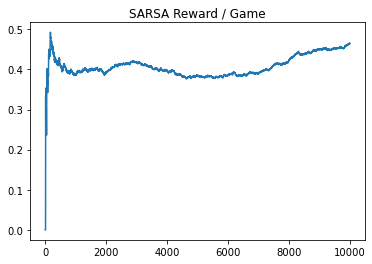

In [9]:
ema_moves = pd.DataFrame(rewards).ewm(halflife=1000).mean()
plt.figure()
plt.title("SARSA Reward / Game")
plt.plot(ema_moves)
plt.show()

### Plot 2: Number of Moves per Game vs. training Time

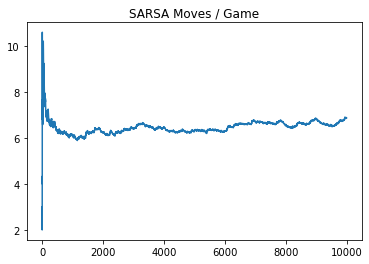

In [10]:
ema_moves = pd.DataFrame(count).ewm(halflife=1000).mean()
plt.figure()
plt.title("SARSA Moves / Game")
plt.plot(ema_moves)
plt.show()

## Task 4
We changed the **dicreased gamma** to 0.7, **set Beta to 0**, **increased eta** to 0.2 and increased the number of hidden layers to 256. 

In [11]:
S, X, allowed_a = env.Initialise_game()

N_h = 256 
epsilon_0 = 0.4  
beta = 0.0      
gamma = 0.7     
eta = 0.02 

## INITALISE YOUR NEURAL NETWORK...
network_adapted_sarsa = Network(N_h, N_in, N_a, eta=eta)

In [12]:
count, rewards = sarsa(network_adapted_sarsa)
print('Adapted SARSA Agent, Average reward:', np.mean(rewards), 'Number of steps: ', np.mean(count))

Ep.: 9900, epsilon: 0.400, moves: 6.833Adapted SARSA Agent, Average reward: 0.3175 Number of steps:  7.7472


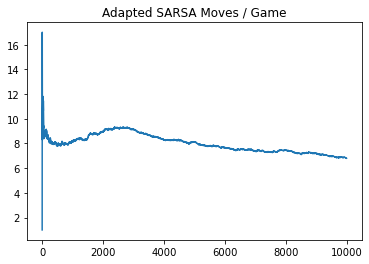

In [13]:
ema_moves = pd.DataFrame(count).ewm(halflife=1000).mean()
plt.figure()
plt.title("Adapted SARSA Moves / Game")
plt.plot(ema_moves)
plt.show()

## Task 5
We implemented **Q-Learning** and **Experience Replay** as well.

### Q-Learning

In [14]:
S, X, allowed_a = env.Initialise_game()

N_h = 256 
epsilon_0 = 0.4  
beta = 0.0      
gamma = 0.7     
eta = 0.02 

## INITALISE YOUR NEURAL NETWORK...
network_qlearn = Network(N_h, N_in, N_a, eta=eta)

In [15]:
def qlearn(network):
    count = []
    rewards = []
    
    for n in range(N_episodes):

        epsilon_f = epsilon_0 / (1 + beta * n)  ## DECAYING EPSILON
        Done = 0  ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
        i = 1  ## COUNTER FOR NUMBER OF ACTIONS
        total_reward = 0 ## COUNTER FOR TOTAL REWARD

        S, X, allowed_a = env.Initialise_game()  ## INITIALISE GAME
        X = X.reshape(len(X), 1)

        if n > 0 and n % 100 == 0:
            print(f"\rEp.: {n}, epsilon: {epsilon_f:.3f}, moves: {np.mean(count[n - 100:]):.2f}", end="")

        Q_values, H = network.forward(X)
        masked_Q_values = Q_values - (1 - allowed_a) * 100000
        a_agent = epsilon_greedy_policy(masked_Q_values, epsilon_f).T

        while Done == 0:  ## START THE EPISODE

            S_next, X_next, allowed_a_next, R, Done = env.OneStep(np.argmax(a_agent))
            X_next = np.array(X_next).reshape(len(X_next), 1)
            total_reward += R

            ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
            if Done == 1:
                output = Q_values * a_agent
                target = R * a_agent
                network.descent(X, target, H, output)
                count.append(i)
                rewards.append(total_reward)
                break

            # IF THE EPISODE IS NOT OVER...
            else:
                Q_values_next, H_next = network.forward(X_next)
                masked_Q_values_next = Q_values_next - (1 - allowed_a_next) * 100000
                # Q-Learning chooses the next step greedily (epsilon=0)
                a_agent_next = epsilon_greedy_policy(masked_Q_values_next, 0.0).T
                future_R = Q_values_next[np.argmax(a_agent_next)]
                output = Q_values * a_agent
                target = (R + gamma * future_R) * a_agent
                network.descent(X, target, H, output)

            # NEXT STATE AND CO. BECOME ACTUAL STATE...     
            S = np.copy(S_next)
            X = np.copy(X_next)
            allowed_a = np.copy(allowed_a_next)
            Q_values = np.copy(Q_values_next)
            H = np.copy(H_next)
            # Q-Learning chooses next action based on greedy policty
            a_agent = epsilon_greedy_policy(masked_Q_values_next, epsilon_f).T

            i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
    return count, rewards

In [16]:
count, rewards = qlearn(network_qlearn)
print('Adapted Q-Learning Agent, Average reward:', np.mean(rewards), 'Number of steps: ', np.mean(count))

Ep.: 9900, epsilon: 0.400, moves: 6.604Adapted Q-Learning Agent, Average reward: 0.2984 Number of steps:  7.7681


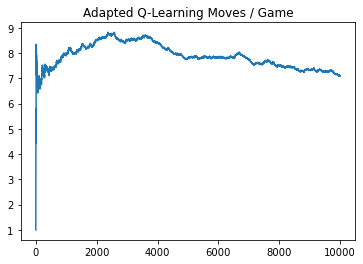

In [17]:
ema_moves = pd.DataFrame(count).ewm(halflife=1000).mean()
plt.figure()
plt.title("Adapted Q-Learning Moves / Game")
plt.plot(ema_moves)
plt.show()

### Experience Replay

In [ ]:
S, X, allowed_a = env.Initialise_game()

N_h = 256 
epsilon_0 = 0.4  
beta = 0.0      
gamma = 0.7     
eta = 0.02 

## INITALISE YOUR NEURAL NETWORK...
network_replay = Network(N_h, N_in, N_a, eta=eta)

In [ ]:
def replay(network):
    count = []
    rewards = []
    
    for n in range(N_episodes):

        epsilon_f = epsilon_0 / (1 + beta * n)  ## DECAYING EPSILON
        Done = 0  ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
        i = 1  ## COUNTER FOR NUMBER OF ACTIONS
        total_reward = 0 ## COUNTER FOR TOTAL REWARD

        S, X, allowed_a = env.Initialise_game()  ## INITIALISE GAME
        X = X.reshape(len(X), 1)

        if n > 0 and n % 100 == 0:
            print(f"\rEp.: {n}, epsilon: {epsilon_f:.3f}, moves: {np.mean(count[n - 100:]):.2f}", end="")

        Q_values, H = network.forward(X)
        masked_Q_values = Q_values - (1 - allowed_a) * 100000
        a_agent = epsilon_greedy_policy(masked_Q_values, epsilon_f).T

        while Done == 0:  ## START THE EPISODE

            S_next, X_next, allowed_a_next, R, Done = env.OneStep(np.argmax(a_agent))
            X_next = np.array(X_next).reshape(len(X_next), 1)
            total_reward += R

            ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
            if Done == 1:
                output = Q_values * a_agent
                target = R * a_agent
                network.descent(X, target, H, output)
                count.append(i)
                rewards.append(total_reward)
                break

            # IF THE EPISODE IS NOT OVER...
            else:
                Q_values_next, H_next = network.forward(X_next)
                masked_Q_values_next = Q_values_next - (1 - allowed_a_next) * 100000
                # Q-Learning chooses the next step greedily (epsilon=0)
                a_agent_next = epsilon_greedy_policy(masked_Q_values_next, 0.0).T
                future_R = Q_values_next[np.argmax(a_agent_next)]
                output = Q_values * a_agent
                target = (R + gamma * future_R) * a_agent
                network.descent(X, target, H, output)

            # NEXT STATE AND CO. BECOME ACTUAL STATE...     
            S = np.copy(S_next)
            X = np.copy(X_next)
            allowed_a = np.copy(allowed_a_next)
            Q_values = np.copy(Q_values_next)
            H = np.copy(H_next)
            # Q-Learning chooses next action based on greedy policty
            a_agent = epsilon_greedy_policy(masked_Q_values_next, epsilon_f).T

            i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
    return count, rewards

In [ ]:
count, rewards = replay(network_replay)
print('Experience Replay Agent, Average reward:', np.mean(rewards), 'Number of steps: ', np.mean(count))

In [ ]:
ema_moves = pd.DataFrame(count).ewm(halflife=1000).mean()
plt.figure()
plt.title("Experience Replay Moves / Game")
plt.plot(ema_moves)
plt.show()

## Task 6
We changed the administration of rewards as follows: Every regular action / move gets a slight punishment of -0.01, while a checkmate results in a reward of 1.0 and stale in a punishment of -1.0. 
Further, we removed the additional input in the state representation (number of possible moves for opponent king, information about checked-state). 


In [21]:
env = Chess_Env(size_board, extended_features=False, R=-0.01, R_draw=-1.0, R_checked=1.0)
S, X, allowed_a = env.Initialise_game()

N_a_s = np.shape(allowed_a)[0]  # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in_s = np.shape(X)[0]  ## INPUT SIZE

N_h_s = 256 
epsilon_0 = 0.4  
beta = 0.0      
gamma = 0.7     
eta = 0.02 

## INITALISE YOUR NEURAL NETWORK...
network_simplified = Network(N_h_s, N_in_s, N_a_s, eta=eta)

In [22]:
count, rewards = qlearn(network_simplified)
print('Less-Information Q-Learning Agent, Average reward:', np.mean(rewards), 'Number of steps: ', np.mean(count))

Ep.: 9900, epsilon: 0.400, moves: 9.629Less-Information Q-Learning Agent, Average reward: -0.17784600000000003 Number of steps:  9.8046


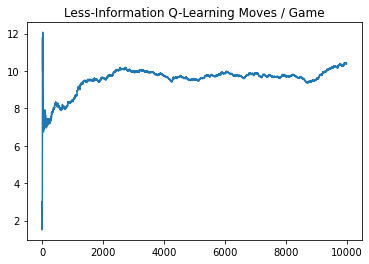

In [23]:
ema_moves = pd.DataFrame(count).ewm(halflife=1000).mean()
plt.figure()
plt.title("Less-Information Q-Learning Moves / Game")
plt.plot(ema_moves)
plt.show()

## Task 7
We implemented RMSProp as part of the Network class.

In [28]:
env = Chess_Env(size_board)
S, X, allowed_a = env.Initialise_game()

N_h = 256 
epsilon_0 = 0.4  
beta = 0.0      
gamma = 0.7     
eta = 0.02 

## INITALISE YOUR NEURAL NETWORK...
network_qlearn_rmsprop = Network(N_h, N_in, N_a, eta=eta, rmsprop=True)

In [29]:
count, rewards = qlearn(network_qlearn_rmsprop)
print('RMSProp Q-Learning Agent, Average reward:', np.mean(rewards), 'Number of steps: ', np.mean(count))

Ep.: 9900, epsilon: 0.400, moves: 9.453RMSProp Q-Learning Agent, Average reward: 0.2116 Number of steps:  8.4421


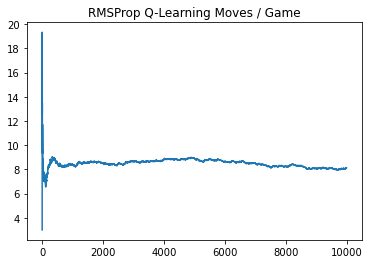

In [30]:
ema_moves = pd.DataFrame(count).ewm(halflife=1000).mean()
plt.figure()
plt.title("RMSProp Q-Learning Moves / Game")
plt.plot(ema_moves)
plt.show()